# Project question 1 - Which car produced the biggest upset in Formula One?

## 1. Importing the first tools and datasets

In [53]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
pd.set_option('display.float_format', '{:.5f}'.format)

results = pd.read_csv("results.csv")
races = pd.read_csv("races.csv")
constructor_results = pd.read_csv("constructor_results.csv")
constructors = pd.read_csv("constructors.csv")
results

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.00000,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.00000,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.00000,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.00000,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.00000,58,+18.014,5708630,43,1,1:27.418,218.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26075,26081,1110,817,213,3,19,16,16,16,0.00000,44,+1:43.071,5053521,25,15,1:50.994,227.169,1
26076,26082,1110,858,3,2,18,17,17,17,0.00000,44,+1:44.476,5054926,37,9,1:50.486,228.213,1
26077,26083,1110,807,210,27,0,18,18,18,0.00000,44,+1:50.450,5060900,26,4,1:49.907,229.415,1
26078,26084,1110,832,6,55,4,\N,R,19,0.00000,23,\N,\N,9,19,1:53.138,222.864,130


# As a new car formula was introduced in 2014 and the technical changes to the cars were relatively small until 2022, we will first look at data from 2014 to 2021. We will use 2014-2020 as a training dataset and apply it to 2021 - the test dataset

# 2. Preparing training data. 
### First, we take all the results from 2014 to 2020 and do some feature engineering - add the circuit information and other such data that the machine learning algorithm is likely to benefit from

In [2]:
races_2014_2020 = races.loc[(races['year'] > 2013) & (races['year'] < 2021)]
races_2014_2020_circuit_data = pd.concat([races_2014_2020['raceId'], races_2014_2020['circuitId'], races_2014_2020['time']], axis=1)

results_2014_2020 = results.loc[(results['raceId'].isin(races_2014_2020['raceId']))]
results_2014_2020 = pd.merge(results_2014_2020, races_2014_2020_circuit_data, on='raceId')

constructor_results_2014_2020 = constructor_results.loc[(constructor_results['raceId'].isin(races_2014_2020['raceId']))]
constructor_results_2014_2020 = constructor_results_2014_2020.drop(columns=['constructorResultsId','status'])
#results_2014_2020 = pd.merge(results_2014_2020, constructor_results_2014_2020, on=['raceId', 'constructorId'])
results_2014_2020 = results_2014_2020.drop(columns=['resultId','driverId','number','position','positionText','time_x'])
results_2014_2020.replace(r"\N", 0, inplace=True)

## converting fastestLapTime to milliseconds
def find_milliseconds(laptime):
    if str(laptime)!='0':
        minutes, seconds_and_ms = str(laptime).split(':')
        seconds, milliseconds = seconds_and_ms.split('.')
        return int(int(minutes) * 60000 + int(seconds) * 1000 + int(milliseconds))
    else:
        return 0
    
def find_time(time):
    if (time == 0):
        return 0
    hours, minutes, seconds = str(time).split(':')
    return (int(hours) * 100) + int(minutes)
results_2014_2020['fastestLapTime'] = results_2014_2020['fastestLapTime'].apply(find_milliseconds)
results_2014_2020['time_y'] = results_2014_2020['time_y'].apply(find_time)

results_2014_2020

,raceId,constructorId,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,circuitId,time_y
0,900,131,3,1,25.00000,57,5578710,19,1,92478,206.436,1,1,600
1,900,1,4,2,18.00000,57,5605487,49,6,93066,205.131,1,1,600
2,900,1,10,3,15.00000,57,5608737,39,5,92917,205.460,1,1,600
3,900,6,5,4,12.00000,57,5613994,57,7,93186,204.867,1,1,600
4,900,3,15,5,10.00000,57,5626349,56,3,92616,206.128,1,1,600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,1047,51,14,16,0.00000,54,0,29,7,101675,196.650,11,24,1310
2823,1047,3,18,17,0.00000,54,0,49,16,102497,195.073,11,24,1310
2824,1047,210,20,18,0.00000,54,0,50,13,101999,196.025,11,24,1310
2825,1047,210,17,19,0.00000,53,0,50,8,101707,196.588,12,24,1310


### Now, repeat these steps for 2021 - the test data

In [3]:
races_2021 = races.loc[(races['year'] == 2021)]
races_2021_circuit_data = pd.concat([races_2021['raceId'], races_2021['circuitId'], races_2021['time']], axis=1)

results_2021 = results.loc[(results['raceId'].isin(races_2021['raceId']))]
results_2021 = pd.merge(results_2021, races_2021_circuit_data, on='raceId')

constructor_results_2021 = constructor_results.loc[(constructor_results['raceId'].isin(races_2021['raceId']))]
constructor_results_2021 = constructor_results_2021.drop(columns=['constructorResultsId','status'])
#results_2021 = pd.merge(results_2021, constructor_results_2021, on=['raceId', 'constructorId'])
results_2021 = results_2021.drop(columns=['resultId','driverId','number','position','positionText','time_x'])
results_2021.replace(r"\N", 0, inplace=True)

results_2021['fastestLapTime'] = results_2021['fastestLapTime'].apply(find_milliseconds)
results_2021['time_y'] = results_2021['time_y'].apply(find_time)

results_2021

,raceId,constructorId,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,circuitId,time_y
0,1052,131,2,1,25.00000,56,5523897,44,4,94015,207.235,1,3,1500
1,1052,9,1,2,18.00000,56,5524642,41,2,93228,208.984,1,3,1500
2,1052,131,3,3,16.00000,56,5561280,56,1,92090,211.566,1,3,1500
3,1052,1,7,4,12.00000,56,5570363,38,6,94396,206.398,1,3,1500
4,1052,9,0,5,10.00000,56,5575944,44,3,93970,207.334,1,3,1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,1073,3,16,16,0.00000,50,0,30,15,89293,212.912,3,24,1300
436,1073,51,14,17,0.00000,33,0,33,16,89442,212.557,6,24,1300
437,1073,3,17,18,0.00000,26,0,23,19,90647,209.732,6,24,1300
438,1073,51,18,19,0.00000,25,0,23,18,89698,211.951,23,24,1300


# For future use, the steps for building the dataset for a period is made into a function:


In [68]:
def get_results_data(year1,year2):
    if year1 == year2:
        races_year = races.loc[(races['year'] == year1)]
    elif year1 < year2:
        races_year = races.loc[(races['year'] >= year1) & (races['year'] <= year2)]
    else:
        races_year = races.loc[(races['year'] <= year1) & (races['year'] >= year2)]
    
    races_year_circuit_data = pd.concat([races_year['raceId'], races_year['circuitId'], races_year['time']], axis=1)

    results_year = results.loc[(results['raceId'].isin(races_year['raceId']))]
    results_year = pd.merge(results_year, races_year_circuit_data, on='raceId')

    results_year = results_year.drop(columns=['resultId','driverId','number','position','positionOrder','positionText','time_x'])
    results_year.replace(r"\N", 0, inplace=True)
    
    results_year['fastestLapTime'] = results_year['fastestLapTime'].apply(find_milliseconds)
    results_year['milliseconds'] = pd.to_numeric(results_year['milliseconds'], errors='coerce').fillna(0)
    results_year['time_y'] = results_year['time_y'].apply(find_time)
    return results_year


In [69]:
get_results_data(2004,2021)["time_y"].value_counts()


1200    2398
1400     642
1310     600
1300     480
600      430
0        360
1600     240
700      238
1900     210
1500     188
500      166
1800     130
1700     128
1210     120
800      116
1100      85
510       80
930       70
430       64
1810      60
1110      60
1910      60
1710      60
1130      44
1430      42
1510      40
610       40
1410      40
300       22
900       20
1010      20
1730      20
2000      18
Name: time_y, dtype: int64

#  3. Building a score prediction model for each constructor in the period 2014-2020 and using it in the year 2021

In [70]:
results_2014_2020 = get_results_data(2014,2020)
results_2021 = get_results_data(2021,2021)

constructors_2021 = results_2021['constructorId'].unique()
print(constructors_2021)
results_2021

[131   9   1   6 213 117  51 214   3 210]


,raceId,constructorId,grid,points,laps,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,circuitId,time_y
0,1052,131,2,25.00000,56,5523897,44,4,94015,207.235,1,3,1500
1,1052,9,1,18.00000,56,5524642,41,2,93228,208.984,1,3,1500
2,1052,131,3,16.00000,56,5561280,56,1,92090,211.566,1,3,1500
3,1052,1,7,12.00000,56,5570363,38,6,94396,206.398,1,3,1500
4,1052,9,0,10.00000,56,5575944,44,3,93970,207.334,1,3,1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,1073,3,16,0.00000,50,0,30,15,89293,212.912,3,24,1300
436,1073,51,14,0.00000,33,0,33,16,89442,212.557,6,24,1300
437,1073,3,17,0.00000,26,0,23,19,90647,209.732,6,24,1300
438,1073,51,18,0.00000,25,0,23,18,89698,211.951,23,24,1300


In [71]:
def predict_ms_results_for_x_from_y(test_results,training_results):
    actual_predicted_ms_results = pd.DataFrame({'constructorId':[], 'predicted':[], 'actual':[]})

    constructor_results_train = training_results.copy().drop(columns=["raceId"])
    constructor_results_test = test_results.copy().drop(columns=["raceId"])

    X_train_ms = constructor_results_train.copy().drop(columns=['milliseconds', 'points'])
    y_train_ms = constructor_results_train['milliseconds']
    X_test_ms = constructor_results_test.copy().drop(columns=['milliseconds', 'points'])
    y_test_ms = constructor_results_test['milliseconds']
    
    regressor = RandomForestRegressor(n_estimators=50, random_state = 1, max_depth = 5, min_samples_split = 2, min_samples_leaf=1)
    regressor.fit(X_train_ms, y_train_ms)
    
    predictions = regressor.predict(X_test_ms)

    actual_predicted_ms_results['constructorId'] = test_results['constructorId']
    actual_predicted_ms_results['predicted'] = predictions

    actual_predicted_ms_results['actual'] = test_results['milliseconds']
    return actual_predicted_ms_results

        



In [96]:
def predict_points_for_year(year):
    training_results = get_results_data(year-10,year-1)
    test_results = get_results_data(year,year)
    accuracy_constructors = pd.DataFrame({'Constructor':[],'MSE':[],'R-squared':[]})
    actual_predicted_points_constructors = pd.DataFrame({'constructorId':[], 'predicted':[], 'actual':[], 'trainingQty':[], 'testQty':[]})
    
    constructors_test = test_results['constructorId'].unique()
    predicted_ms_table = predict_ms_results_for_x_from_y(test_results,training_results)
    
    test_results['milliseconds'] = predicted_ms_table['predicted']

    for constructor in constructors_test:
        constructor_results_train = training_results.loc[training_results['constructorId'] == constructor].drop(columns=["raceId"])
        constructor_results_test = test_results.loc[test_results['constructorId'] == constructor].drop(columns=["raceId"])

        X_train = constructor_results_train.copy().drop(columns=['points'])
        if len(X_train) != 0:
            y_train = constructor_results_train['points']
            X_test = constructor_results_test.copy().drop(columns=['points'])
            y_test = constructor_results_test['points']

            regressor = RandomForestRegressor(n_estimators=50, random_state = 1, max_depth = 5, min_samples_split = 2, min_samples_leaf=1)
            
            regressor.fit(X_train, y_train)
            predictions = regressor.predict(X_test)
            #following line was used for finding best hyperparametres
            #print(cross_val_score(regressor, X_train, y_train, cv=5, scoring='r2'))

            accuracy_constructors.loc[len(accuracy_constructors.index)] = [constructor, mean_squared_error(y_test, predictions), r2_score(y_test, predictions)]
            actual_predicted_points_constructors.loc[len(actual_predicted_points_constructors.index)] = [constructor, predictions.sum(), y_test.sum(), len(training_results), len(test_results)]
    
    actual_predicted_points_constructors = pd.merge(actual_predicted_points_constructors, constructors, on='constructorId').drop(columns=["url"])
    return accuracy_constructors, actual_predicted_points_constructors

In [125]:
year = 2021
predicted_points = predict_points_for_year(year)
predicted_points[1]

,constructorId,predicted,actual,trainingQty,testQty,constructorRef,name,nationality
0,131.00000,626.32008,604.50000,4181.00000,440.00000,mercedes,Mercedes,German
1,9.00000,565.58098,578.50000,4181.00000,440.00000,red_bull,Red Bull,Austrian
2,1.00000,285.32029,274.00000,4181.00000,440.00000,mclaren,McLaren,British
3,6.00000,339.74489,322.50000,4181.00000,440.00000,ferrari,Ferrari,Italian
4,213.00000,128.51772,142.00000,4181.00000,440.00000,alphatauri,AlphaTauri,Italian
5,51.00000,54.61308,13.00000,4181.00000,440.00000,alfa,Alfa Romeo,Swiss
6,3.00000,44.26654,23.00000,4181.00000,440.00000,williams,Williams,British
7,210.00000,11.73356,0.00000,4181.00000,440.00000,haas,Haas F1 Team,American


Our models for the first six featured constructors were pretty accurate, hence they produced no major upsets in the 2021 season. The 7th constructor (with constructorId 3), however, showed a pretty large deviation, and as the points show, it can be said that this constructor performed somewhat worse than what the model predicted, although this would have no effect on the final positions.

Now, let us try visualizing the data

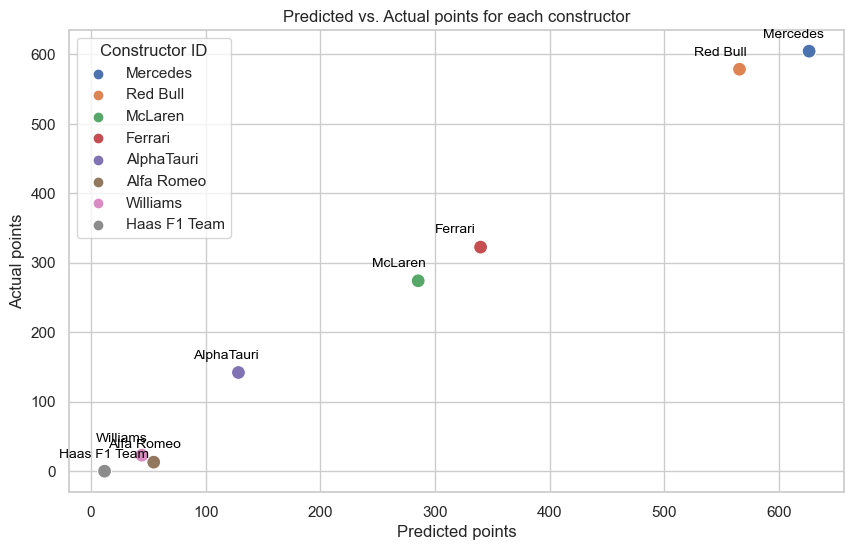

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10,6))

scatter = sns.scatterplot(x="predicted", y="actual", hue="name",
                          data=predicted_points[1], s=100, legend='brief')

for line in range(0, predicted_points[1].shape[0]):
    scatter.text(predicted_points[1]["predicted"][line] - 40, 
                      predicted_points[1]["actual"][line] + 20, 
                      predicted_points[1]['name'][line],
                      horizontalalignment='left', size='small', color='black')

plt.xlabel('Predicted points')
plt.ylabel('Actual points')
plt.title('Predicted vs. Actual points for each constructor')
plt.legend(title='Constructor ID')

plt.show()

<Figure size 1500x600 with 0 Axes>

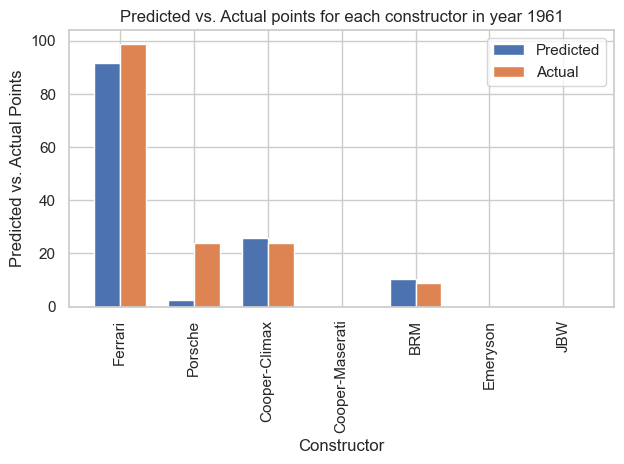

In [11]:
plt.figure(figsize=(15,6))
fig, ax = plt.subplots()
bar_width = 0.35
bar_positions1 = range(len(predicted_points[1]))
bar_positions2 = [pos + bar_width for pos in bar_positions1]

ax.bar(bar_positions1, predicted_points[1]['predicted'], width = bar_width, label='Predicted')
ax.bar(bar_positions2, predicted_points[1]['actual'], width = bar_width, label='Actual')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions1])
ax.set_xticklabels(predicted_points[1]['name'], rotation=90)
ax.set_xlabel('Constructor')
ax.set_ylabel('Predicted vs. Actual Points')
ax.set_title(f'Predicted vs. Actual points for each constructor in year {year}')
ax.legend()

plt.tight_layout()
plt.show()

# 4. Run the functions for each possible year (1961 - 2023) and collect all the information to find the largest upset in F1 history

## For this, we need the predicted vs. actual point comparison of each constructor in each season and look at the highest differences recorded

### Let us first look at 2000-2023, finding the biggest upset in the 21st century

In [12]:
all_mses = pd.DataFrame({'Constructor': [], 'Year': [], 'MSE': []})

for year in range(2000,2024):
    predicted_points = predict_points_for_year(year)
    for index, row in predicted_points[0].iterrows():
        all_mses.loc[len(all_mses.index)] = [row['Constructor'], year, row['MSE']]

all_mses.sort_values(by='MSE', ascending=False)

,Constructor,Year,MSE
96,9.00000,2010.00000,87.94539
95,1.00000,2010.00000,70.95711
94,6.00000,2010.00000,64.18579
137,3.00000,2014.00000,50.97500
103,1.00000,2011.00000,38.21000
...,...,...,...
22,3.00000,2002.00000,0.00000
23,1.00000,2002.00000,0.00000
28,17.00000,2002.00000,0.00000
29,15.00000,2002.00000,0.00000


In [13]:
predict_points_for_year(2010)[1]

,constructorId,predicted,actual,trainingQty,testQty,constructorRef,name,nationality
0,6.00000,155.00000,396.00000,3995.00000,456.00000,ferrari,Ferrari,Italian
1,1.00000,185.50000,454.00000,3995.00000,456.00000,mclaren,McLaren,British
2,9.00000,201.60000,498.00000,3995.00000,456.00000,red_bull,Red Bull,Austrian
3,10.00000,9.70000,68.00000,3995.00000,456.00000,force_india,Force India,Indian
4,3.00000,19.95000,69.00000,3995.00000,456.00000,williams,Williams,British
5,4.00000,59.60000,163.00000,3995.00000,456.00000,renault,Renault,French
6,5.00000,1.10000,13.00000,3995.00000,456.00000,toro_rosso,Toro Rosso,Italian
7,15.00000,10.70000,44.00000,3995.00000,456.00000,sauber,Sauber,Swiss


### A quick internet search reveals that the points system was changed for the 2010 season, something that the algorithm does not take into account. To make sure this does not affect our results further, we should add divison by total points to the generated dataframes. This finds the ratio. A new and improved points quantity function is also provided.


In [111]:
def improved_predict_points_ratio_for_year(year):
    training_results = get_results_data(year-5,year-1) #only previous 5 years are used for training, as rules and participants change often
    training_results['points'] = training_results['points']
    test_results = get_results_data(year,year)
    test_results['points'] = test_results['points']

    predicted_actual_points = pd.DataFrame({'predicted': [], 'actual': []})
    accuracy_constructors = pd.DataFrame({'Constructor':[],'MSE':[],'R-squared':[]})
    actual_predicted_points_constructors = pd.DataFrame({'constructorId':[], 'predictedRatio':[], 'actualRatio':[], 'trainingQty':[], 'testQty':[]})
    
    constructors_test = test_results['constructorId'].unique()
    predicted_ms_table = predict_ms_results_for_x_from_y(test_results,training_results)
    
    test_results['milliseconds'] = predicted_ms_table['predicted']

    for constructor in constructors_test:
        constructor_results_train = training_results.loc[training_results['constructorId'] == constructor].drop(columns=["raceId"])
        constructor_results_test = test_results.loc[test_results['constructorId'] == constructor].drop(columns=["raceId"])

        X_train = constructor_results_train.copy().drop(columns=['points'])
        if len(X_train) != 0:
            y_train = constructor_results_train['points']
            X_test = constructor_results_test.copy().drop(columns=['points'])
            y_test = constructor_results_test['points']

            regressor = RandomForestRegressor(n_estimators=50, random_state = 1, max_depth = 5, min_samples_split = 2, min_samples_leaf=1)

            regressor.fit(X_train, y_train)
            predictions = regressor.predict(X_test)
            
            accuracy_constructors.loc[len(accuracy_constructors.index)] = [constructor, mean_squared_error(y_test, predictions), r2_score(y_test, predictions)]
            predicted_actual_points.loc[len(predicted_actual_points.index)] = [predictions.sum(), y_test.sum()]
            actual_predicted_points_constructors.loc[len(actual_predicted_points_constructors.index)] = [constructor, 0.0, 0.0, len(training_results), len(test_results)]

    
    actual_predicted_points_constructors['predictedRatio'] = predicted_actual_points['predicted'].div(predicted_actual_points['predicted'].sum())
    actual_predicted_points_constructors['actualRatio'] = predicted_actual_points['actual'].div(predicted_actual_points['actual'].sum())
   
    actual_predicted_points_constructors = pd.merge(actual_predicted_points_constructors, constructors, on='constructorId').drop(columns=["url"])
    return accuracy_constructors, actual_predicted_points_constructors

def improved_predict_points_quantity_for_year(year):
    training_results = get_results_data(year-5,year-1) #only previous 5 years are used for training, as rules and participants change often
    training_results['points'] = training_results['points']
    test_results = get_results_data(year,year)
    test_results['points'] = test_results['points']

    predicted_actual_points = pd.DataFrame({'predicted': [], 'actual': []})
    accuracy_constructors = pd.DataFrame({'Constructor':[],'MSE':[],'R-squared':[]})
    actual_predicted_points_constructors = pd.DataFrame({'constructorId':[], 'predictedPoints':[], 'actualPoints':[], 'trainingQty':[], 'testQty':[]})
    
    constructors_test = test_results['constructorId'].unique()
    predicted_ms_table = predict_ms_results_for_x_from_y(test_results,training_results)
    
    test_results['milliseconds'] = predicted_ms_table['predicted']

    for constructor in constructors_test:
        constructor_results_train = training_results.loc[training_results['constructorId'] == constructor].drop(columns=["raceId"])
        constructor_results_test = test_results.loc[test_results['constructorId'] == constructor].drop(columns=["raceId"])

        X_train = constructor_results_train.copy().drop(columns=['points'])
        if len(X_train) != 0:
            y_train = constructor_results_train['points']
            X_test = constructor_results_test.copy().drop(columns=['points'])
            y_test = constructor_results_test['points']

            regressor = RandomForestRegressor(n_estimators=50, random_state = 1, max_depth = 5, min_samples_split = 2, min_samples_leaf=1)

            regressor.fit(X_train, y_train)
            predictions = regressor.predict(X_test)
            
            accuracy_constructors.loc[len(accuracy_constructors.index)] = [constructor, mean_squared_error(y_test, predictions), r2_score(y_test, predictions)]
            predicted_actual_points.loc[len(predicted_actual_points.index)] = [predictions.sum(), y_test.sum()]
            actual_predicted_points_constructors.loc[len(actual_predicted_points_constructors.index)] = [constructor, 0.0, 0.0, len(training_results), len(test_results)]

    
    actual_predicted_points_constructors['predictedPoints'] = predicted_actual_points['predicted']
    actual_predicted_points_constructors['actual'] = predicted_actual_points['actual']
   
    actual_predicted_points_constructors = pd.merge(actual_predicted_points_constructors, constructors, on='constructorId').drop(columns=["url"])
    return accuracy_constructors, actual_predicted_points_constructors

In [115]:
improved_predict_points_ratio_for_year(2021)[1]

,constructorId,predictedRatio,actualRatio,trainingQty,testQty,constructorRef,name,nationality
0,131.00000,0.30481,0.30881,4637.00000,440.00000,mercedes,Mercedes,German
1,9.00000,0.27749,0.29553,4637.00000,440.00000,red_bull,Red Bull,Austrian
2,1.00000,0.14272,0.13997,4637.00000,440.00000,mclaren,McLaren,British
3,6.00000,0.15862,0.16475,4637.00000,440.00000,ferrari,Ferrari,Italian
4,213.00000,0.06361,0.07254,4637.00000,440.00000,alphatauri,AlphaTauri,Italian
5,51.00000,0.02681,0.00664,4637.00000,440.00000,alfa,Alfa Romeo,Swiss
6,3.00000,0.02004,0.01175,4637.00000,440.00000,williams,Williams,British
7,210.00000,0.00590,0.00000,4637.00000,440.00000,haas,Haas F1 Team,American


In [116]:
improved_predict_points_quantity_for_year(2021)[1]

,constructorId,predictedPoints,actualPoints,trainingQty,testQty,constructorRef,name,nationality
0,131.00000,619.64619,604.50000,4637.00000,440.00000,mercedes,Mercedes,German
1,9.00000,564.10113,578.50000,4637.00000,440.00000,red_bull,Red Bull,Austrian
2,1.00000,290.13957,274.00000,4637.00000,440.00000,mclaren,McLaren,British
3,6.00000,322.45089,322.50000,4637.00000,440.00000,ferrari,Ferrari,Italian
4,213.00000,129.32105,142.00000,4637.00000,440.00000,alphatauri,AlphaTauri,Italian
5,51.00000,54.50030,13.00000,4637.00000,440.00000,alfa,Alfa Romeo,Swiss
6,3.00000,40.73204,23.00000,4637.00000,440.00000,williams,Williams,British
7,210.00000,12.00023,0.00000,4637.00000,440.00000,haas,Haas F1 Team,American


## In some seasons, it's visible that more points were awarded than what the model predicted, hence it is important that we look at both the divison of points by total AND the actual points difference. For this, let's create one final function that uses both old functions and has this tweak!

In [121]:
def find_biggest_upsets(year1,year2):
    all_results = pd.DataFrame({'Constructor': [], 'Year': [], 'Ratio difference': [], 'Points difference': [], 'Predicted ratio': [], 'Actual ratio': [], 'Predicted amount': [], 'Actual amount': []})

    for year in range(year1, year2 + 1):
        predictions_1 = improved_predict_points_ratio_for_year(year)[1]
        predictions_2 = improved_predict_points_quantity_for_year(year)[1]
        predictions = pd.merge(predictions_1, predictions_2.drop(columns=["trainingQty", "testQty", "constructorRef", "name", "nationality"]), on='constructorId')
        for index, row in predictions.iterrows():
            all_results.loc[len(all_results.index)] = [row['name'], year, (row['predictedRatio'] - row['actualRatio']), (row['predictedPoints'] - row['actualPoints']), row['predictedRatio'], row['actualRatio'], row['predictedPoints'], row['actualPoints']]
    
    return all_results.sort_values(by=['Ratio difference', 'Points difference'], ascending=True)

upsets = find_biggest_upsets(1955,2023)

C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMet

C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMet

C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\larsjesp\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMet

In [122]:
upsets

,Constructor,Year,Ratio difference,Points difference,Predicted ratio,Actual ratio,Predicted amount,Actual amount
200,Tyrrell,1971,-0.36975,-88.00000,0.00000,0.36975,0.00000,88.00000
188,Brabham-Ford,1969,-0.24727,-68.00000,0.00000,0.24727,0.00000,68.00000
146,Cooper-Maserati,1966,-0.23670,-40.96000,0.08780,0.32450,8.04000,49.00000
179,McLaren-Ford,1968,-0.19705,-46.12000,0.04329,0.24034,9.88000,56.00000
683,Red Bull,2009,-0.19134,-86.65630,0.13422,0.32556,66.84370,153.50000
...,...,...,...,...,...,...,...,...
145,Ferrari,1966,0.12741,-4.86333,0.40555,0.27815,37.13667,42.00000
64,Epperly,1959,0.12817,18.32000,0.17036,0.04219,23.32000,5.00000
155,Brabham-Repco,1967,0.13918,15.92000,0.50682,0.36765,115.92000,100.00000
169,Brabham-Repco,1968,0.18266,41.44236,0.23417,0.05150,53.44236,12.00000


### While the head of the upsets table is usable right off the bat, the tail of the upsets table suffers from the massive points fluctuations of early F1. Here, a little bit of manual review will help us find more suitable candidates for the worst letdown in F1 history

In [152]:
upsets.tail(10)

,Constructor,Year,Ratio difference,Points difference,Predicted ratio,Actual ratio,Predicted amount,Actual amount
206,BRM,1971,0.09765,1.96130,0.27412,0.17647,43.96130,42.00000
183,Lotus-Ford,1969,0.09954,25.48916,0.31408,0.21455,84.48916,59.00000
100,Ferrari,1962,0.10897,13.72771,0.25973,0.15075,43.72771,30.00000
144,BRM,1966,0.11455,-2.89234,0.33971,0.22517,31.10766,34.00000
199,Ferrari,1971,0.11840,4.63583,0.30327,0.18487,48.63583,44.00000
145,Ferrari,1966,0.12741,-4.86333,0.40555,0.27815,37.13667,42.00000
64,Epperly,1959,0.12817,18.32000,0.17036,0.04219,23.32000,5.00000
155,Brabham-Repco,1967,0.13918,15.92000,0.50682,0.36765,115.92000,100.00000
169,Brabham-Repco,1968,0.18266,41.44236,0.23417,0.05150,53.44236,12.00000
93,Cooper-Climax,1961,0.25177,62.51733,0.40562,0.15385,86.51733,24.00000


In [166]:
tail = pd.DataFrame(upsets.loc[93]).transpose()
tail = tail.append(upsets.loc[169]).append(upsets.loc[64]).append(upsets.loc[100]).append(upsets.loc[183])

C:\Users\larsjesp\AppData\Local\Temp\ipykernel_7140\3369004882.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tail = tail.append(upsets.loc[169]).append(upsets.loc[64]).append(upsets.loc[100]).append(upsets.loc[183])
C:\Users\larsjesp\AppData\Local\Temp\ipykernel_7140\3369004882.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tail = tail.append(upsets.loc[169]).append(upsets.loc[64]).append(upsets.loc[100]).append(upsets.loc[183])
C:\Users\larsjesp\AppData\Local\Temp\ipykernel_7140\3369004882.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tail = tail.append(upsets.loc[169]).append(upsets.loc[64]).append(upsets.loc[100]).append(upsets.loc[183])
C:\Users\larsjesp\AppData\Local\Temp\ipykernel_7140\3369004882.py:2

## Now that we have the biggest upsets from both ends, let's visualize this data

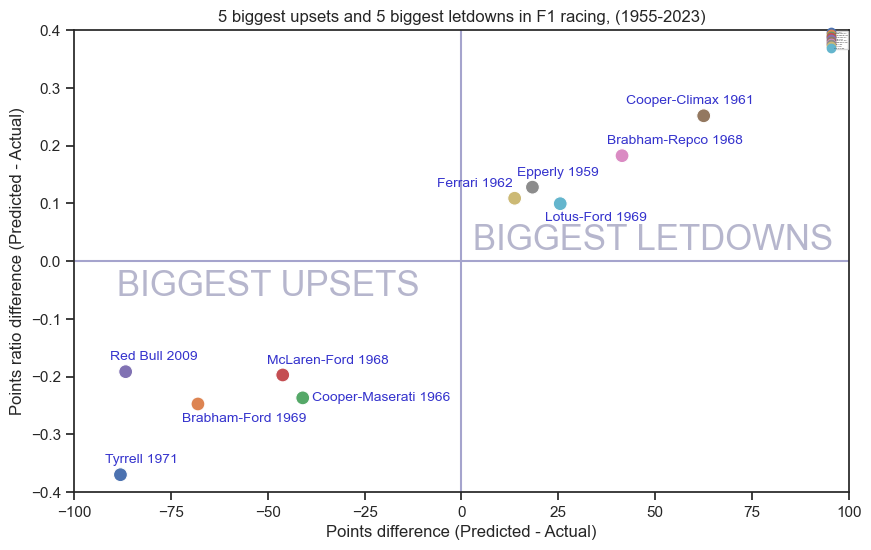

In [300]:
upsets_top5_bottom5 = pd.concat([upsets.head(5),tail], ignore_index=True)
upsets_top5_bottom5["ConstructorPlusYear"] = upsets_top5_bottom5.apply(lambda row: f"{row['Constructor']} {row['Year']}", axis=1)

sns.set(style="ticks")


plt.figure(figsize=(10,6))

scatter = sns.scatterplot(x="Points difference", y="Ratio difference", hue=("ConstructorPlusYear"),
                          data=upsets_top5_bottom5, s=100, legend='brief', color='#3533cd')
plt.axvline(x=0, color='#A5A4CD')
plt.axhline(y=0, color='#A5A4CD')


for line in range(0, upsets_top5_bottom5.shape[0]):
    if upsets_top5_bottom5["Year"][line] in [1969]:
        scatter.text(upsets_top5_bottom5["Points difference"][line] - 4, 
                          upsets_top5_bottom5["Ratio difference"][line] - 0.03, 
                          (upsets_top5_bottom5["Constructor"][line] + " " + str(upsets_top5_bottom5["Year"][line])),
                          horizontalalignment='left', size='small', color='#3533cd')
    elif upsets_top5_bottom5["Year"][line] in [1966]:
        scatter.text(upsets_top5_bottom5["Points difference"][line] + 2.5, 
                      upsets_top5_bottom5["Ratio difference"][line] - 0.005, 
                          (upsets_top5_bottom5["Constructor"][line] + " " + str(upsets_top5_bottom5["Year"][line])),
                          horizontalalignment='left', size='small', color='#3533cd')
    elif upsets_top5_bottom5["Year"][line] in [1961,1962]:
        scatter.text(upsets_top5_bottom5["Points difference"][line] - 20, 
                          upsets_top5_bottom5["Ratio difference"][line] + 0.020, 
                          (upsets_top5_bottom5["Constructor"][line] + " " + str(upsets_top5_bottom5["Year"][line])),
                          horizontalalignment='left', size='small', color='#3533cd')
    else:
        scatter.text(upsets_top5_bottom5["Points difference"][line] - 4, 
                          upsets_top5_bottom5["Ratio difference"][line] + 0.02, 
                          (upsets_top5_bottom5["Constructor"][line] + " " + str(upsets_top5_bottom5["Year"][line])),
                          horizontalalignment='left', size='small', color='#3533cd')

scatter.text(-89,-0.06, "BIGGEST UPSETS",size=25, color='#B6B6CD')
scatter.text(3,0.02, "BIGGEST LETDOWNS",size=25, color='#B6B6CD')


plt.xlabel('Points difference (Predicted - Actual)')
plt.xlim(-100,100)
plt.ylim(-0.4,0.4)
plt.ylabel('Points ratio difference (Predicted - Actual)')
plt.title('5 biggest upsets and 5 biggest letdowns in F1 racing, (1955-2023)')
legend = plt.legend(prop={'size': 0})

plt.show()

In [291]:
tail

,Constructor,Year,Ratio difference,Points difference,Predicted ratio,Actual ratio,Predicted amount,Actual amount
93,Cooper-Climax,1961,0.25177,62.51733,0.40562,0.15385,86.51733,24.00000
169,Brabham-Repco,1968,0.18266,41.44236,0.23417,0.05150,53.44236,12.00000
64,Epperly,1959,0.12817,18.32000,0.17036,0.04219,23.32000,5.00000
100,Ferrari,1962,0.10897,13.72771,0.25973,0.15075,43.72771,30.00000
183,Lotus-Ford,1969,0.09954,25.48916,0.31408,0.21455,84.48916,59.00000
